# Data Science Bootcamp Week 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
url = "https://data.cityofnewyork.us/api/views/6fi9-q3ta/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url)
# parse datetime and add useful time parts
df["hour_beginning"] = pd.to_datetime(df["hour_beginning"])
df["hour"] = df["hour_beginning"].dt.hour
df["month"] = df["hour_beginning"].dt.month
df["date"] = df["hour_beginning"].dt.date
df["day_name"] = df["hour_beginning"].dt.day_name()
# sort chronologically
df = df.sort_values("hour_beginning").reset_index(drop=True)
# forward-fill weather columns
for c in ["temperature", "precipitation", "weather_summary"]:
    df[c] = df[c].ffill()

C:\Users\tanu2\AppData\Local\Temp\ipykernel_17884\2687967777.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["hour_beginning"] = pd.to_datetime(df["hour_beginning"])


**Q1. Filter the data to include only weekdays (Monday to Friday) and plot a line graph showing the pedestrian counts for each day of the week.**

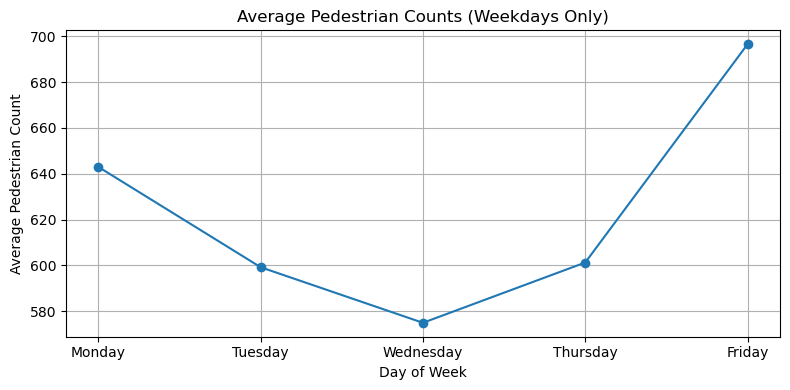

In [2]:
# filter to weekdays
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
df_weekdays = df[df["day_name"].isin(weekdays)].copy()
# aggregate: average pedestrians per day of week
day_order = pd.CategoricalDtype(categories=weekdays, ordered=True)
df_weekdays["day_name"] = df_weekdays["day_name"].astype(day_order)
avg_by_day = (
    df_weekdays.groupby("day_name", observed=True)["Pedestrians"]
    .mean()
    .reindex(weekdays)
)
# plot
plt.figure(figsize=(8,4))
plt.plot(avg_by_day.index, avg_by_day.values, marker="o")
plt.title("Average Pedestrian Counts (Weekdays Only)")
plt.xlabel("Day of Week")
plt.ylabel("Average Pedestrian Count")
plt.grid(True)
plt.tight_layout()
plt.show()

**Q2. Track pedestrian counts on the Brooklyn Bridge for the year 2019 and analyze how different weather conditions influence pedestrian activity in that year. Sort the pedestrian count data by weather summary to identify any correlations (with a correlation matrix) between weather patterns and pedestrian counts for the selected year.**

Pedestrians by Weather (2019):


,count,mean,median,std
weather_summary,,,,
partly-cloudy-day,1773,1574.093627,1632.0,866.684380
clear-day,1413,1382.183298,1380.0,876.267199
wind,4,679.000000,403.0,901.998522
cloudy,1818,541.737624,120.5,737.719776
rain,607,229.822076,52.0,373.117494
snow,38,222.631579,29.5,344.718328
fog,22,212.409091,80.0,330.504039
sleet,8,178.250000,155.5,188.028683
partly-cloudy-night,1213,52.596867,10.0,119.868003



Correlation with Pedestrians (2019):


Pedestrians               1.000000
wx_partly-cloudy-day      0.497867
temperature               0.358922
wx_clear-day              0.339758
wx_wind                  -0.000170
wx_sleet                 -0.017091
wx_fog                   -0.026457
wx_snow                  -0.034052
wx_cloudy                -0.082244
precipitation            -0.105182
wx_rain                  -0.138581
wx_partly-cloudy-night   -0.282698
wx_clear-night           -0.377989
Name: Pedestrians, dtype: float64

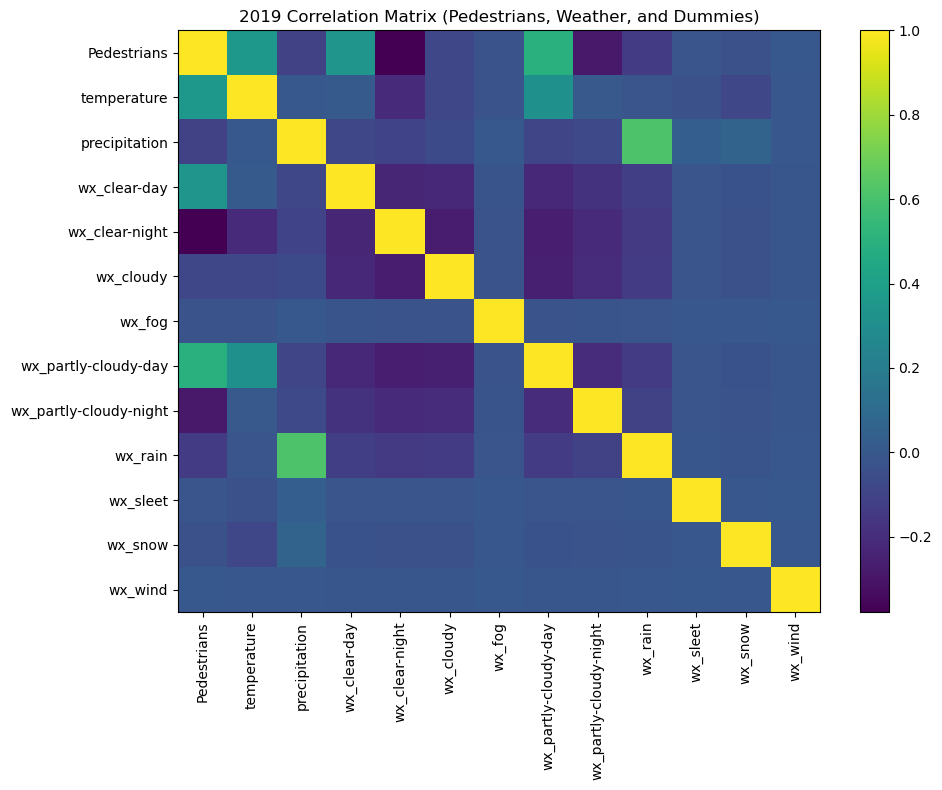

In [3]:
# subset to 2019
df_2019 = df[df["hour_beginning"].dt.year == 2019].copy()
# summary by weather condition, sorted by mean pedestrians
wx_summary = (
    df_2019.groupby("weather_summary", dropna=False)["Pedestrians"]
    .agg(["count", "mean", "median", "std"])
    .sort_values("mean", ascending=False)
)
print("Pedestrians by Weather (2019):")
display(wx_summary.head(20))
# build a correlation matrix including weather as one-hot indicators
weather_dummies = pd.get_dummies(df_2019["weather_summary"], prefix="wx", dummy_na=False)
corr_df_2019 = pd.concat(
    [df_2019[["Pedestrians", "temperature", "precipitation"]], weather_dummies],
    axis=1
)
corr_matrix_2019 = corr_df_2019.corr(numeric_only=True)
# show correlations of pedestrians with temperature, precipitation, and each weather dummy
corr_with_peds = corr_matrix_2019.loc["Pedestrians"].sort_values(ascending=False)
print("\nCorrelation with Pedestrians (2019):")
display(corr_with_peds)
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix_2019, interpolation="nearest", aspect="auto")
plt.colorbar()
plt.title("2019 Correlation Matrix (Pedestrians, Weather, and Dummies)")
plt.xticks(range(corr_matrix_2019.shape[1]), corr_matrix_2019.columns, rotation=90)
plt.yticks(range(corr_matrix_2019.shape[0]), corr_matrix_2019.index)
plt.tight_layout()
plt.show()

**Q3. Implement a custom function to categorize time of day into morning, afternoon, evening, and night, and create a new column in the DataFrame to store these categories. Use this new column to analyze pedestrian activity patterns throughout the day.**

Average pedestrian count by time of day:


time_of_day
Morning       614.543099
Afternoon    1694.841305
Evening       426.206776
Night          13.001993
Name: Pedestrians, dtype: float64

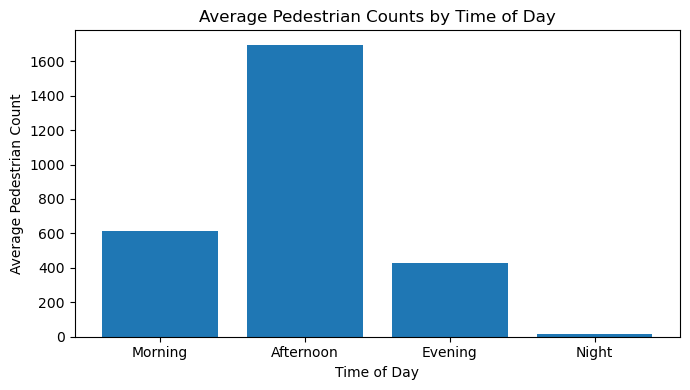


Weekday × Time-of-Day (Average Pedestrians):


time_of_day,Morning,Afternoon,Evening,Night
day_name,,,,
Monday,579.9,1572.2,407.9,11.9
Tuesday,566.8,1450.9,369.2,10.1
Wednesday,552.4,1380.9,356.5,10.0
Thursday,534.5,1473.2,388.0,9.4
Friday,622.0,1725.9,425.3,12.9


In [4]:
# define a custom function for time-of-day bins
def categorize_time_of_day(hour: int) -> str:
    """
    Returns one of: 'Night', 'Morning', 'Afternoon', 'Evening'
    Night:     0–5
    Morning:   6–11
    Afternoon: 12–17
    Evening:   18–23
    """
    if 0 <= hour <= 5:
        return "Night"
    elif 6 <= hour <= 11:
        return "Morning"
    elif 12 <= hour <= 17:
        return "Afternoon"
    else:
        return "Evening"
# create new column
df["time_of_day"] = df["hour"].apply(categorize_time_of_day)
# order categories for nice plotting
tod_order = ["Morning", "Afternoon", "Evening", "Night"]
df["time_of_day"] = pd.Categorical(df["time_of_day"], categories=tod_order, ordered=True)
# average pedestrians by time of day
avg_by_tod = (
    df.groupby("time_of_day", observed=True)["Pedestrians"]
    .mean()
    .reindex(tod_order)
)
print("Average pedestrian count by time of day:")
display(avg_by_tod)
# plotting
plt.figure(figsize=(7,4))
plt.bar(avg_by_tod.index, avg_by_tod.values)
plt.title("Average Pedestrian Counts by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Average Pedestrian Count")
plt.tight_layout()
plt.show()
# cross-tab with weekdays to see patterns by day + time block
weekday_tod = (
    df[df["day_name"].isin(["Monday","Tuesday","Wednesday","Thursday","Friday"])]
    .groupby(["day_name","time_of_day"], observed=True)["Pedestrians"]
    .mean()
    .unstack("time_of_day")
    .loc[["Monday","Tuesday","Wednesday","Thursday","Friday"]]
)
print("\nWeekday × Time-of-Day (Average Pedestrians):")
display(weekday_tod.round(1))